In [352]:
import cv2 as cv
from matplotlib import pyplot as plt
import json
import numpy as np
import os

In [353]:
config = json.load(open("../config.json"))
print(config)
antrenare_folder = "../../antrenare/"
evaluare_folder = "../../evaluare/"
auxiliare_folder = "../../imagini_auxiliare/"

{'base_image_path': './template_tabla.jpg', 'score_tracker': [1, 2, 3, 4, 5, 6, 0, 2, 5, 3, 4, 6, 2, 2, 0, 3, 5, 4, 1, 6, 2, 4, 5, 5, 0, 6, 3, 4, 2, 0, 1, 5, 1, 3, 4, 4, 4, 5, 0, 6, 3, 5, 4, 1, 3, 2, 0, 0, 1, 1, 2, 3, 6, 3, 5, 2, 1, 0, 6, 6, 5, 2, 1, 2, 5, 0, 3, 3, 5, 0, 6, 1, 4, 0, 6, 3, 5, 1, 4, 2, 6, 2, 3, 1, 6, 5, 6, 2, 0, 4, 0, 1, 6, 4, 4, 1, 6, 6, 3, 100], 'board': [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

In [354]:
base_img = cv.imread("../../my_antrenare/images/3_14.jpg")
first_img = cv.imread("../../my_antrenare/images/3_15.jpg")

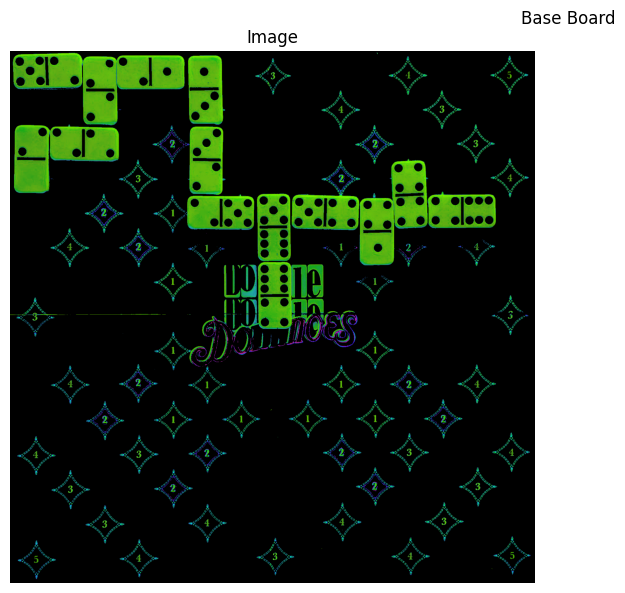

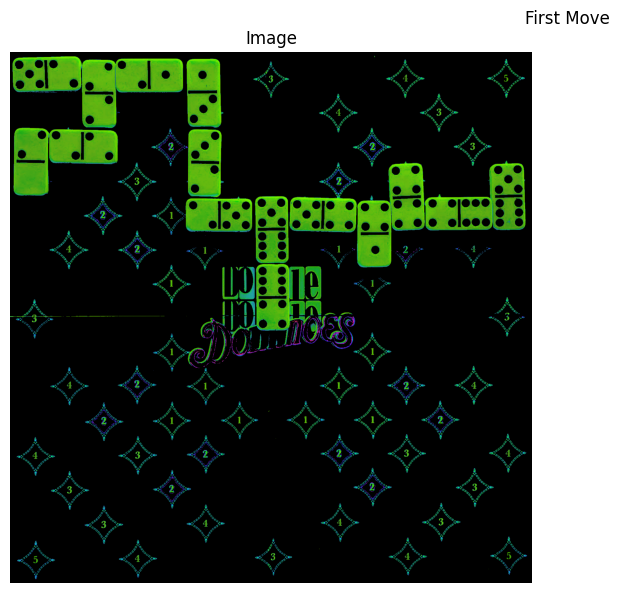

In [355]:
import sys

sys.path.insert(0, "../")
from util import crop_board, denoise, sharpen, edge_detect, color_filter, print_image

first_move_cropped = crop_board(first_img)


def pipeline(image):
    image = crop_board(image)
    # hMin, sMin, vMin = 95, 130, 135
    # hMax, sMax, vMax = 140, 255, 255
    # image = color_filter(
    #     image, h_range=(hMin, hMax), s_range=(sMin, sMax), v_range=(vMin, vMax)
    # )
    image = color_filter(image, np.uint8([200, 240, 250]), 60)
    image = cv.cvtColor(image, cv.COLOR_HSV2BGR)
    # image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # image = denoise(image)
    # image = sharpen(image)
    # image = edge_detect(image)
    return image


base_board = pipeline(base_img.copy())
first_move = pipeline(first_img.copy())
print_image(base_board, title="Base Board", fft=False)
print_image(first_move, title="First Move", fft=False)

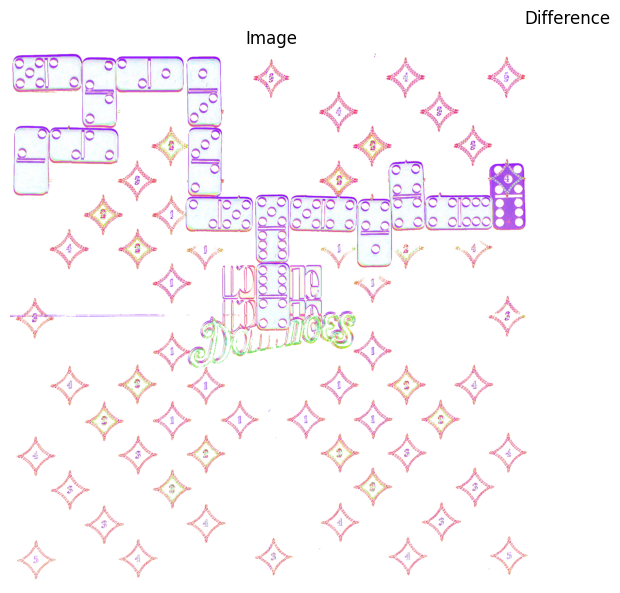

In [356]:
# Resize images to the same size
size = (
    max(base_board.shape[1], first_move.shape[1]),
    max(base_board.shape[0], first_move.shape[0]),
)
base_board_diff = cv.resize(base_board, size, interpolation=cv.INTER_AREA)
first_move_diff = cv.resize(first_move, size, interpolation=cv.INTER_AREA)

difference = 255 - cv.absdiff(first_move_diff, base_board_diff)

print_image(difference, title="Difference", fft=False)

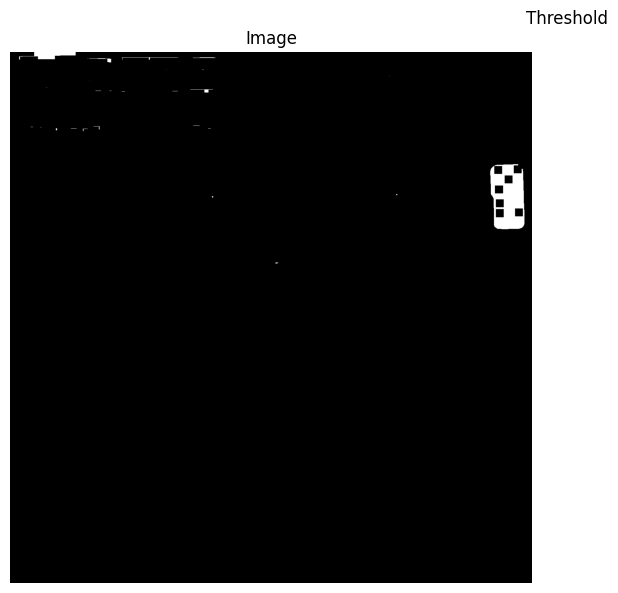

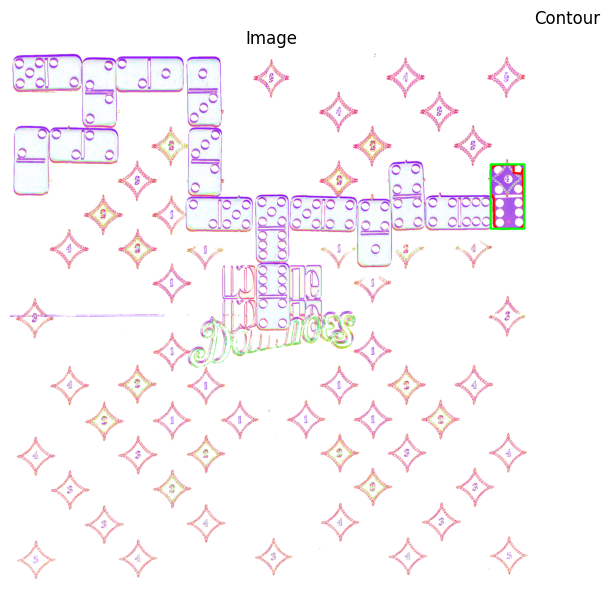

In [357]:
# identify rectangle domino piece 2x1
image = difference.copy()
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(gray, 160, 255, cv.THRESH_BINARY_INV)
# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
thresh = cv.erode(thresh, np.ones((3, 3), np.uint8), iterations=3)
thresh = cv.morphologyEx(
    thresh, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=12
)
# thresh = cv.morphologyEx(thresh, cv.MORPH_GRADIENT, np.ones((3, 3), np.uint8))

print_image(thresh, title="Threshold", fft=False)

cnts, hierarchy = cv.findContours(
    thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
)

good_contours = []
for contour in cnts:
    area = cv.contourArea(contour)
    if area > 15:
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = max(w / h, h / w)
        if 1.9 < aspect_ratio < 2.1:
            # print(f"Area: {area}, Aspect Ratio: {aspect_ratio}")
            good_contours.append(contour)

contour = max(cnts, key=cv.contourArea)

contour_poly = cv.approxPolyDP(contour, 3, True)
bounding_rect = cv.boundingRect(contour_poly)

output = image.copy()
output = cv.drawContours(image, [contour_poly], -1, (255, 0, 0), 6)
output = cv.rectangle(output, bounding_rect, (0, 255, 0), 6)

print_image(output, title="Contour", fft=False)

5 6


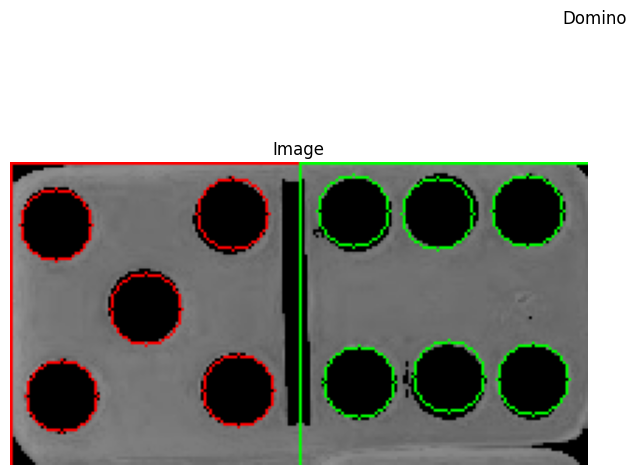

In [358]:
x, y, w, h = bounding_rect
domino = first_move_diff.copy()[y : y + h, x : x + w]
domino = cv.cvtColor(domino, cv.COLOR_BGR2GRAY)
# domino = cv.GaussianBlur(domino, (5, 5), 0)
cv.imwrite("domino.jpg", domino)


if h > w:
    domino = cv.rotate(domino, cv.ROTATE_90_COUNTERCLOCKWISE)
    w, h = h, w


left_rect_start = (0, 0)
left_rect_end = (w // 2, h)

right_rect_start = (w // 2, 0)
right_rect_end = (w, h)

left_square = domino[
    left_rect_start[1] : left_rect_end[1], left_rect_start[0] : left_rect_end[0]
]
right_square = domino[
    right_rect_start[1] : right_rect_end[1], right_rect_start[0] : right_rect_end[0]
]


def circles(image):
    circles = cv.HoughCircles(
        image,
        cv.HOUGH_GRADIENT_ALT,
        dp=1,
        minDist=25,
        param1=400,
        param2=0.2,
        minRadius=8,
        maxRadius=16,
    )

    if circles is not None:
        # print("circles:", circles)
        # print("circles len:", len(circles))
        # print("circles[0] len:", len(circles[0]))
        circles = np.uint16(np.around(circles))
        return circles
    return np.array([[]])


left_circles = circles(left_square)
right_circles = circles(right_square)

domino = cv.cvtColor(domino, cv.COLOR_GRAY2RGB)

for circle in left_circles[0, :]:
    x, y, r = circle
    cv.circle(domino, (x, y), r, (0, 0, 255), 1)

for circle in right_circles[0, :]:
    x, y, r = circle
    cv.circle(domino, (x + w // 2, y), r, (0, 255, 0), 1)

left_circles = len(left_circles[0, :])
right_circles = len(right_circles[0, :])
print(left_circles, right_circles)

cv.rectangle(domino, left_rect_start, left_rect_end, (0, 0, 255), 1)
cv.rectangle(domino, right_rect_start, right_rect_end, (0, 255, 0), 1)
print_image(domino, title="Domino", fft=False, gray=False)